In [50]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import natural_cubic_spline_stack_overflow as ncs
from math import *

In [51]:
import warnings
from scipy.optimize import curve_fit
from scipy import integrate, stats
import natural_cubic_spline_stack_overflow as ncs
import dynamic_stock_model as dsm 
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2nd scenario: UK government plan

This scenario is a inflow-driven scenario. UK government plan to build 300 000 new buildings by 2030 and probably the same amount each year until 2050. As this plan is fot the UK, we need to reduce the number for England.

In [52]:
DSM_AB_model = pd.read_csv('Model/DSM_model_AB.csv')
DSM_AB_model=DSM_AB_model.set_index('Unnamed: 0')
DSM_MFH_model = pd.read_csv('Model/DSM_model_MFH.csv')
DSM_MFH_model=DSM_MFH_model.set_index('Unnamed: 0')
DSM_SFH_model = pd.read_csv('Model/DSM_model_SFH.csv')
DSM_SFH_model=DSM_SFH_model.set_index('Unnamed: 0')
DSM_TH_model = pd.read_csv('Model/DSM_model_TH.csv')
DSM_TH_model=DSM_TH_model.set_index('Unnamed: 0')
DSM=pd.read_csv('Model/DSM_TOT.csv')
DSM=DSM.set_index('DSM')

DSM_model=DSM_AB_model.copy(deep=True)
DSM_model['Stock']=DSM_AB_model['Stock']+DSM_MFH_model['Stock']+DSM_SFH_model['Stock']+DSM_TH_model['Stock']
DSM_model['Stock change']=DSM_AB_model['Stock change']+DSM_MFH_model['Stock change']+DSM_SFH_model['Stock change']+DSM_TH_model['Stock change']

display(DSM_AB_model)

,Population,Stock,PpD,Stock Change,Inflow,Outflow,Stock change
Unnamed: 0,,,,,,,
1600,0,NaN,0,0,0.000000,NaN,NaN
1601,0,0.000000,0,0,0.000000,0.000000,0.000000
1602,0,0.000000,0,0,0.000000,0.000000,0.000000
1603,0,0.000000,0,0,0.000000,0.000000,0.000000
1604,0,0.000000,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2046,0,794756.983772,0,0,22880.623885,2809.772285,20070.851600
2047,0,815321.813339,0,0,23445.575667,2880.746100,20564.829566
2048,0,836385.719049,0,0,24017.372652,2953.466942,21063.905710


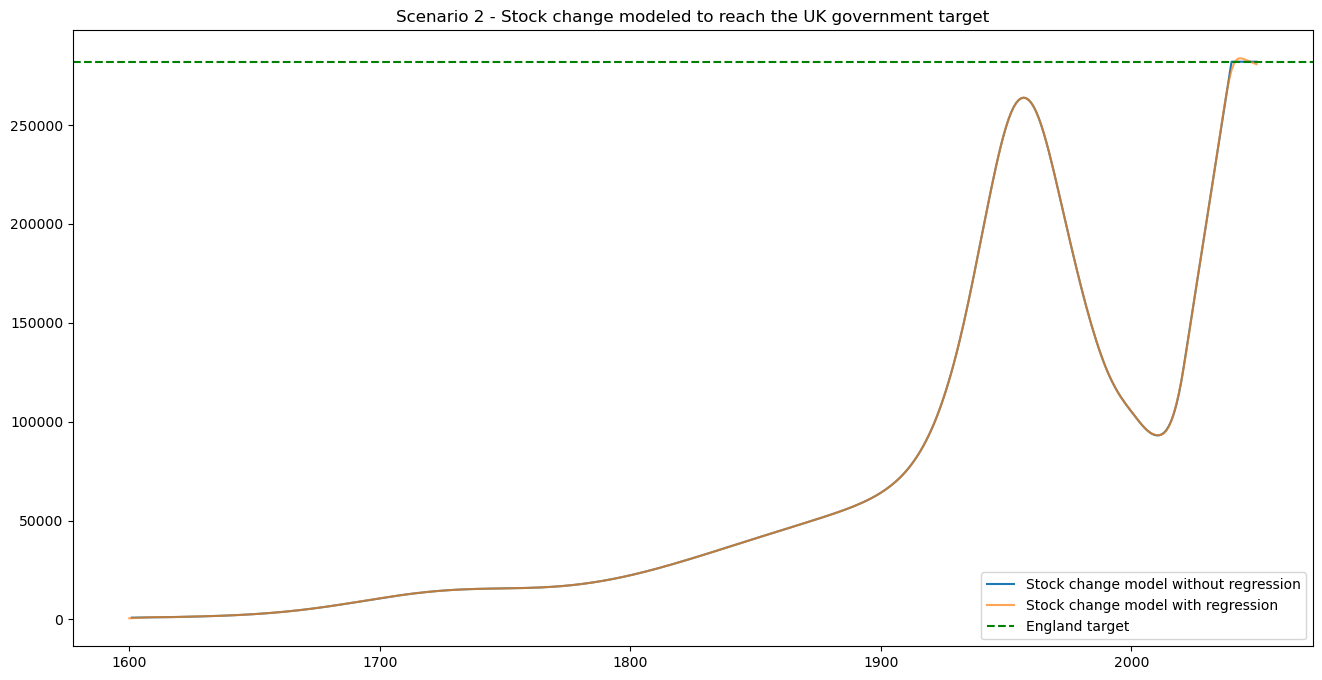

In [85]:
plt.figure(figsize=(16,8))

DSM_model_s2=DSM_model.copy(deep=True)
DSM_model_s2['Stock change'] = DSM_model_s2['Stock change']
target_UK=300000
ratioUK_En=0.94
target_En=target_UK * ratioUK_En
for i in range (2022,2041):
    DSM_model_s2.loc[i,'Stock change']=DSM_model_s2.loc[i-1,'Stock change']+(target_En - DSM_model_s2.loc[2021,'Stock change']) / (2040-2021)
for i in range (2041,2051):
    DSM_model_s2.loc[i,'Stock change']=target_En

DSM_model['Stock change'] = DSM_model_s2['Stock change']

inputs=np.array(DSM_model_s2.index)
outputs=DSM_model_s2['Stock change'].fillna(0)

no_knots = int(len(inputs)/5)
ncs_model = ncs.get_natural_cubic_spline_model(inputs, outputs, minval=min(inputs), maxval=max(inputs), n_knots = no_knots)
O_model = ncs_model.predict(inputs)
fit_label = f'natural cubic splines with {no_knots} knots'  

DSM_model_s2['Stock change']=O_model
    
plt.plot(DSM_model['Stock change'],label='Stock change model without regression')
plt.plot(DSM_model_s2['Stock change'],label='Stock change model with regression', alpha=0.7)

plt.axhline(y=target_En,label='England target', linestyle='--', color='green')
plt.title('Scenario 2 - Stock change modeled to reach the UK government target')
plt.legend()
plt.show()

# inputs=np.array(DSM_model_s2.index[-29:])
# outputs=DSM_model_s2.loc[2022:2051,'Stock change']

# no_knots = int(len(inputs)/5)
# ncs_model = ncs.get_natural_cubic_spline_model(inputs, outputs, minval=min(inputs), maxval=max(inputs), n_knots = no_knots)
# O_model = ncs_model.predict(inputs)
# fit_label = f'natural cubic splines with {no_knots} knots'  

# DSM_model_s2.loc[2022:2051,'Stock change']=O_model
    
# plt.plot(DSM_model_s2['Stock change'])


We now have modeled the stock change that is needed to reach the target set up by the UK government. We now can get the stock.

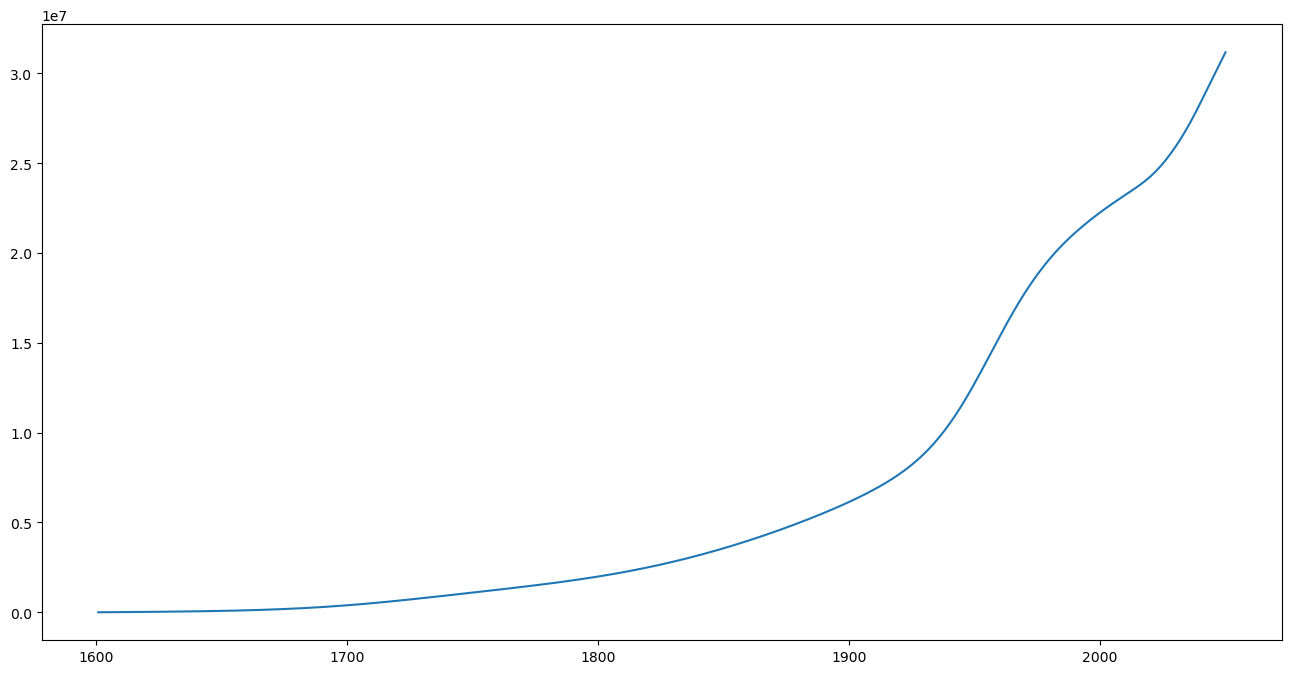

In [57]:
plt.figure(figsize=(16,8))

for i in range (2021,2051):
    DSM_model_s2.loc[i,'Stock'] = DSM_model_s2.loc[i-1,'Stock'] + DSM_model.loc[i,'Stock change']


plt.plot(DSM_model_s2['Stock'])

From this stock, and the population (we keep the same projection than for BAU) it is now possible to get the PpD for scenario 2.

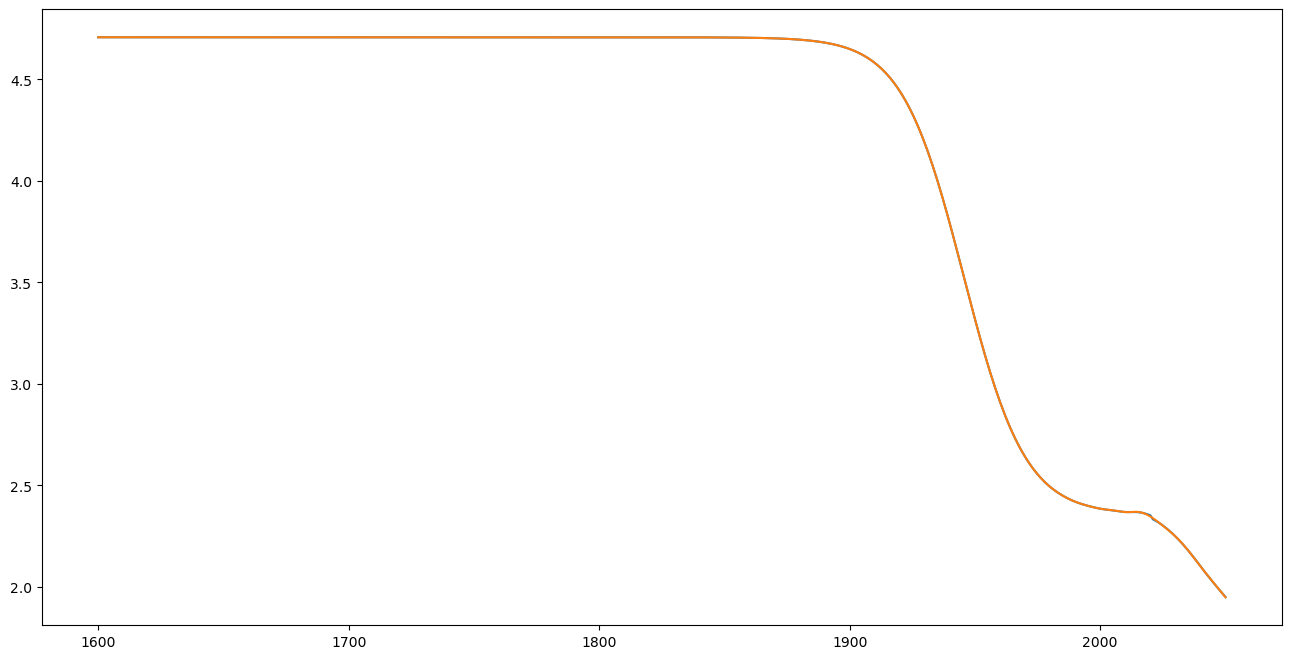

In [73]:
plt.figure(figsize=(16,8))

pop = DSM['Population']
PpD = pop[-30:] / DSM_model_s2['Stock'].fillna(0)[-30:]
PpD_s2 = DSM['PpD']
PpD_s2[-30:] = PpD


inputs=np.array(PpD_s2.index)
outputs=PpD_s2

no_knots = int(len(inputs)/5)
ncs_model = ncs.get_natural_cubic_spline_model(inputs, outputs, minval=min(inputs), maxval=max(inputs), n_knots = no_knots)
O_model = ncs_model.predict(inputs)
fit_label = f'natural cubic splines with {no_knots} knots'  

PpD_s2_final=O_model

PpD_s2_final = pd.DataFrame(PpD_s2_final, index = PpD_s2.index, columns = ['PpD'])

plt.plot(PpD_s2, label='PpD')
plt.plot(PpD_s2_final)
plt.show()

PpD_s2_final.to_csv('Model/PpD.csv')


From that PpD, we can now use the same model than previously, by running the file '1-from-pop-to-stock.ipynb', in replacing the PpD by the one we have just calculated. Then, we can run the files 2 and 3 to get all the outputs needed.